<h1 align="center"><b>Anomaly Localization using CNN with GAP Layer</b></h1>

<h3 align="center">Leveraging Global Average Pooling (GAP) in CNNs for Enhanced Malaria Cell Image Analysis: Classification and Precise Anomaly Detection</h3>

---
---
## Table of Contents

1. [Introduction](#Introduction)
2. [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
3. [Model Building](#Model-Building)
   - 4.1 [Model Architecture](#Model-Architecture)
   - 4.2 [Model Compilation](#Model-Compilation)
4. [Training the Model](#Training-the-Model)
   - 5.1 [Data Partitioning](#Data-Partitioning)
   - 5.2 [Implementing Data Augmentation](#Implementing-Data-Augmentation)
   - 5.3 [Configuring Training Callbacks](#Configuring-Training-Callbacks)
   - 5.4 [Executing Model Training](#Executing-Model-Training)
5. [Model Evaluation](#Model-Evaluation)
   - 6.1 [Evaluation Metrics](#Evaluation-Metrics)
   - 6.2 [Confusion Matrix](#Confusion-Matrix)
6. [Class Activation Mapping (CAM)](#Class-Activation-Mapping-(CAM))

---
---

## Introduction

In this comprehensive notebook, we tackle the dual challenges of classifying cells as either parasitized by malaria or uninfected and localizing anomalies within cells using advanced deep learning techniques. Our approach centers on the deployment of a Convolutional Neural Network (CNN) enhanced with a Global Average Pooling (GAP) layer. This combination not only streamlines the classification process but also facilitates precise anomaly detection within microscopic images of blood cells.

Traditionally, the analysis of blood cell images for malaria diagnosis has been a labor-intensive task, requiring significant expertise in microscopy. The goal of this project is to significantly automate this process, leveraging the CNN model's ability to learn complex patterns in data. By doing so, we aim to improve both the efficiency and accuracy of malaria diagnosis, which is crucial for timely and effective treatment interventions.

This notebook is meticulously structured to walk you through our end-to-end methodology. It begins with data loading and preprocessing. We ignore the EDA step here as it has been already done in the notebook "Malaria_Cell_Classifier_CNN.ipynb". We then delve into the construction and training of our CNN model, detailing how the inclusion of a GAP layer not only aids in classifying images more effectively but also plays a pivotal role in localizing the specific areas of interest within the cells that signify infection. Finally, we evaluate our model's performance and discuss the implications of our findings for malaria diagnosis and beyond using displaying the heatmap plots of infected cells.

---
---

## Data Loading and Preprocessing

In [1]:
# Extend system path to include 'Scripts' and 'Utilities' directories for module imports
import sys
sys.path.extend(['../Scripts', '../Utilities'])

In [2]:
# Importing general utility functions from the 'import_libraries' module
from import_libraries import get_general_utils, get_data_handling_and_viz_libs

# Get data handling
np, plt, sns, cv2 = get_data_handling_and_viz_libs()

# Getting the Path and os modules from the general utilities
Path, os = get_general_utils()

# Setting the path to the dataset. 
dataset_path = Path("path/to/your/dataset/directory")


In [3]:
# Import Image Processing utilities
from image_processing import load_and_preprocess_images

# Define constants
SIZE = 64
COLOR_MODE = 'rgb'  

# Initialize lists for dataset and labels
infected_data, infected_labels = load_and_preprocess_images(dataset_path/'Parasitized', SIZE, COLOR_MODE)
uninfected_data, uninfected_labels   = load_and_preprocess_images(dataset_path/'Uninfected' , SIZE, COLOR_MODE)

# Combine the datasets and labels
dataset = infected_data   + uninfected_data
labels  = infected_labels + uninfected_labels

# Display basic statistics
print(f"Total images: {len(dataset)}")
print(f"Number of 'Infected' images: {len(infected_data)}")
print(f"Number of 'Uninfected' images:  {len(uninfected_data)}")

Total images: 27558
Number of 'Infected' images: 13779
Number of 'Uninfected' images:  13779


---
---

## Model Building

In this section, we focus on constructing and compiling our Convolutional Neural Network (CNN) model for the task of classifying malaria-infected cells. The process involves two primary stages:

- **Model Architecture**: We outline the architecture of our CNN, carefully detailing each layer, its type, and the connectivity amongst them. A standout feature of our model is the incorporation of a Global Average Pooling (GAP) layer, which not only contributes to reducing the model's complexity but also facilitates the extraction of spatial hierarchies of features crucial for anomaly localization. The choice of architecture is instrumental, as it directly influences the model's ability to discern and learn from the intricate patterns present in our image data.

- **Model Compilation**: After defining the architecture, we compile the model. This step involves specifying the optimizer, loss function, and metrics for evaluating the model’s performance. The compilation settings play a vital role in how the model learns during the training process.


### Model Architecture

In [4]:
# Import necessary layers and functions
from import_libraries import get_core_keras_layers, get_training_components, get_gap_test_and_localization_libs

# Get core keras layers
Input, Conv2D, Dense, _, BatchNormalization, Dropout, Model = get_core_keras_layers()
# Get GAP layer
GlobalAveragePooling2D, _, _, _ = get_gap_test_and_localization_libs()
# Get training components
l2, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard = get_training_components()

/Users/mahdihabibi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
# Define convolution block
def conv_block(input_tensor, num_filters):
    """
    Adds a convolutional block to the model.

    Parameters:
    - input_tensor: Input tensor to the convolutional block
    - num_filters: Number of filters for the convolutional layers

    Returns:
    - Tensor after applying convolutional layers, BatchNormalization, and Dropout
    """
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_tensor)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    return x

# Define dense block
def dense_block(input_tensor, num_neurons):
    """
    Adds a dense block to the model.

    Parameters:
    - input_tensor: Input tensor to the dense block
    - num_neurons: Number of neurons in the dense layer

    Returns:
    - Tensor after applying Dense layer, BatchNormalization, and Dropout
    """
    x = Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.001))(input_tensor)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    return x

# Define the input shape
INPUT_SHAPE = (SIZE, SIZE, 3)

# Input layer
inp = Input(shape=INPUT_SHAPE)

# Creating convolutional blocks
x = conv_block(inp, 32)
x = conv_block(x, 32)
x = conv_block(x, 64)
x = conv_block(x, 64)

# Flattening and dense layers
x = GlobalAveragePooling2D()(x)

# Output layer for binary classification
out = Dense(2, activation='softmax')(x)

# Final Model Construction
model = Model(inputs=inp, outputs=out)


### Model Compilation

In [6]:
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf

# Configure the optimizer 
optimizer = Adam(learning_rate=0.001)

# Compile the model with explicit configurations
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  
              metrics=[
                  'accuracy',  # Overall classification accuracy
                  tf.keras.metrics.Precision(name='precision'), 
                  tf.keras.metrics.Recall(name='recall') 
              ])

# Print model summary
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                             

---
---

## Training the Model

In [7]:
from import_libraries import get_data_preprocessing_tools, get_sklearn_components, get_keras_utilities

### Data Partitioning

In [8]:
# Get Scikit-learn components
train_test_split, _, _, _, _ = get_sklearn_components()

# Get Keras utilities
to_categorical = get_keras_utilities()

# Splitting the Dataset into Training + Validation and Test sets
X = np.array(dataset)
Y = to_categorical(np.array(labels))

# Splitting the data into a combined (training + validation) set, and a separate test set.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Splitting the (Training + Validation) set into individual Training and Validation sets
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (16534, 64, 64, 3)
y_train shape: (16534, 2)
X_test shape: (5512, 64, 64, 3)
y_test shape: (5512, 2)
X_val shape: (5512, 64, 64, 3)
y_val shape: (5512, 2)


### Implementing Data Augmentation

In [9]:
# Get data preprocessing tools
ImageDataGenerator = get_data_preprocessing_tools()

# Define the ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range    = 15,
    width_shift_range = False,
    height_shift_range= False,
    zoom_range        = False,
    horizontal_flip   = True,
    vertical_flip     = True
)

# to create the augmented data generator
augmented_data = data_generator.flow(X_train, y_train, batch_size = 64)

### Configuring Training Callbacks

In [10]:
l2, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard = get_training_components()

#### Model Checkpoint
*   Callback to save the model with the best validation loss
*   This ensures that we always save the model in its best-performing state on the validation data

In [11]:
model_checkpoint = ModelCheckpoint(
    filepath = '/Models/best_CNN_for_Malaria_classifier_with_GAP.keras',
    monitor  = 'accuracy',  
    save_best_only = True,
    verbose  = 1,
    mode     = 'max'    
)

#### Early Stopping
*   Callback to stop training when the validation loss stops improving
*   This helps in preventing overfitting and reduces unnecessary training time

In [12]:
early_stopping = EarlyStopping(
    monitor  = 'val_loss',
    patience = 5,
    verbose  = 1,
    mode     = 'min'    
)

#### Adjusting the learning rate
*   Callback to reduce the learning rate when a metric has stopped improving
*   This helps in achieving smoother convergence through training

In [13]:
reduce_lr = ReduceLROnPlateau(
    monitor  = 'val_loss', 
    factor   = 0.1,   # Multiplicative factor of learning rate reduction
    patience = 4,
    min_lr   = 0.0001, # Lower bound on the learning rate
    verbose  = 1
)

In [14]:
# List of callbacks to be used in model training
callbacks_list = [model_checkpoint, early_stopping, reduce_lr]

### Executing Model Training

In [15]:
# Training the Model
results = model.fit(
    augmented_data,
    verbose = 1,
    epochs  = 15,
    validation_data = (X_val, y_val),
    steps_per_epoch = len(X_train) // 64,  # Number of batches per epoch
    callbacks = callbacks_list
)

Epoch 1/15
258/258 [==============================] - ETA: 0s - loss: 0.5468 - accuracy: 0.8001 - precision: 0.8001 - recall: 0.8001
Epoch 1: accuracy improved from -inf to 0.80012, saving model to /Volumes/D/GitHub-Portfolio/MalariaPred/Models/best_CNN_for_Malaria_classifier_with_GAP.keras
258/258 [==============================] - 19s 69ms/step - loss: 0.5468 - accuracy: 0.8001 - precision: 0.8001 - recall: 0.8001 - val_loss: 2.0739 - val_accuracy: 0.5011 - val_precision: 0.5011 - val_recall: 0.5011 - lr: 0.0010
Epoch 2/15
258/258 [==============================] - ETA: 0s - loss: 0.2765 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407
Epoch 2: accuracy improved from 0.80012 to 0.94068, saving model to /Volumes/D/GitHub-Portfolio/MalariaPred/Models/best_CNN_for_Malaria_classifier_with_GAP.keras
258/258 [==============================] - 18s 70ms/step - loss: 0.2765 - accuracy: 0.9407 - precision: 0.9407 - recall: 0.9407 - val_loss: 0.4222 - val_accuracy: 0.8948 - val_precision

## Model Evaluation

In [16]:
# Get Scikit-learn components
_ , classification_report, confusion_matrix, roc_curve, auc = get_sklearn_components()

### Evaluation Metrics

In [17]:
# Evaluate the model
scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(f"Test Loss: {scores[0]:.5f}")

# Predict classes with the model
predictions = model.predict(np.array(X_test))
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to single-column format
y_test_single_column = np.argmax(y_test, axis=1)

# Generate classification report and confusion matrix
print(classification_report(y_test_single_column, predicted_classes))

Accuracy: 96.37%
Test Loss: 0.12952
173/173 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2797
           1       0.95      0.98      0.96      2715

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



In [18]:
# Calculate the average training loss over all epochs
average_train_loss = np.mean(results.history['loss'])

# Get the training loss from the last epoch
final_train_loss = results.history['loss'][-1]

print(f"Average Training Loss: {average_train_loss:.5f}")
print(f"Final Training Loss: {final_train_loss:.5f}")

Average Training Loss: 0.20061
Final Training Loss: 0.13796


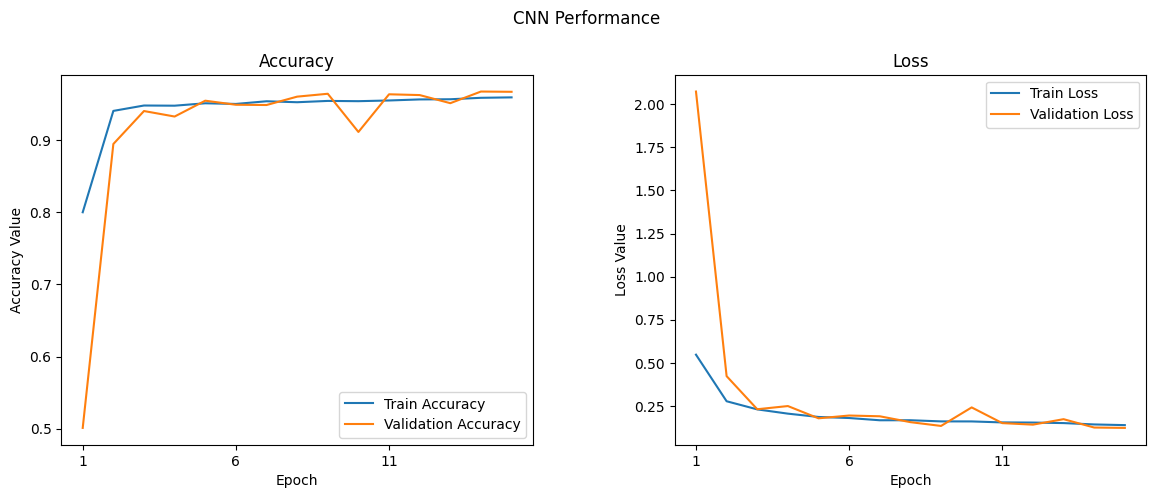

In [19]:
def plot_training_history(results):
    """
    Plot the training and validation accuracy and loss over epochs.

    This function visualizes the model's training progress. It plots two graphs:
    - The first graph shows the training and validation accuracy over epochs.
    - The second graph shows the training and validation loss over epochs.

    Parameters:
    - history: A Keras History object containing the model's training history.

    The function creates a subplot with two axes objects and plots the accuracy and
    loss values stored in the history object.
    """

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('CNN Performance', fontsize=12)
    fig.subplots_adjust(top=0.85, wspace=0.3)

    # Extract the number of epochs and create a list of epoch numbers
    max_epoch = len(results.history['accuracy'])
    epoch_list = list(range(1, max_epoch + 1))

    # Plot training and validation accuracy
    ax1.plot(epoch_list, results.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, results.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    ax1.legend(loc="best")

    # Plot training and validation loss
    ax2.plot(epoch_list, results.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, results.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    ax2.legend(loc="best")

    # Display the plots
    plt.show()

# Call the function to plot
plot_training_history(results)

### Confusion Matrix

In [20]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_single_column, predicted_classes)
print(conf_matrix)

[[2664  133]
 [  67 2648]]


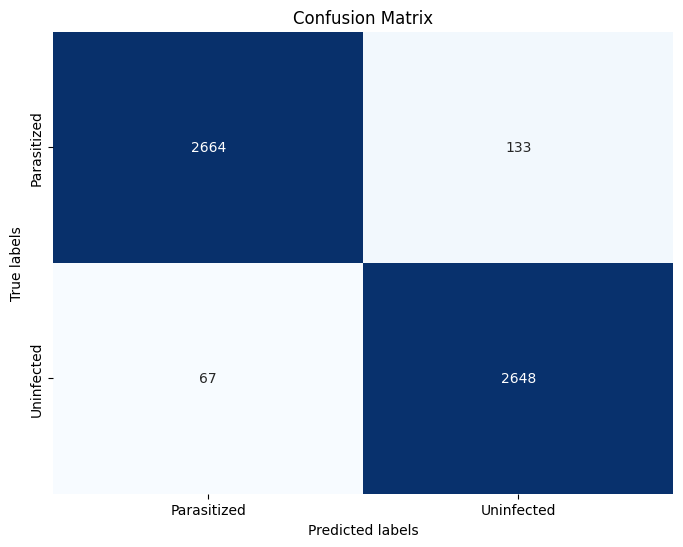

In [21]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.show()

## Class Activation Mapping (CAM)

In [22]:
_, scipy, Rectangle, peak_local_max = get_gap_test_and_localization_libs()

In [23]:
def load_predicted_images(X_test, predicted_classes, class_idx=0):
    """
    Filters images predicted as a specific class and returns them as an array.

    Parameters:
    - X_test: The test dataset images.
    - predicted_classes: The array of predicted classes for each image in X_test.
    - class_idx: The class index for which to filter images (default is 0).

    Returns:
    - An array of images predicted to be in the specified class.
    """
    predicted_image_idx = np.where(predicted_classes == class_idx)[0]
    predicted_images = np.array([X_test[i] for i in predicted_image_idx])
    return predicted_images

In [24]:
def class_activation_map(imgage, model, layer_name='conv2d_23'):
    """
    Generates a heatmap for a given image using the specified model and layer.

    Parameters:
    - img: The input image for which to generate the heatmap.
    - model: The trained model to use for prediction and heatmap generation.
    - layer_name: The name of the last convolutional layer in the model.

    Returns:
    - The generated heatmap as a 2D numpy array.
    """
    # Predict the class of the input image using the model.
    predction = model.predict(np.expand_dims(imgage, axis=0))
    # Identify the predicted class index.
    predction_class = np.argmax(predction)  
    
    # Extract the weights of the last layer, which are used to highlight the heatmap areas.
    last_layer_weights = model.layers[-1].get_weights()[0] 
    # Weights for the predicted class. 
    last_layer_weights_for_prediction = last_layer_weights[:, predction_class]
    
    # get the final convulational layer
    final_conv_layer = model.get_layer("conv2d_23")
    
    # Create a model to fetch the last convolutional layer's activations (maps).
    last_conv_model = Model(inputs=model.input, outputs=final_conv_layer.output)
    
    # Get the activations from the last convolutional layer for the input image.
    last_conv_output = last_conv_model.predict(np.expand_dims(imgage, axis=0))
    # squeeze conv map to shape image to size (4, 4, 64)
    last_conv_output = np.squeeze(last_conv_output)  
    
    # Calculate the ratio needed to upsample the activation maps to the size of the input image.
    height_ratio = imgage.shape[0] / last_conv_output.shape[0]
    width_ratio = imgage.shape[1] / last_conv_output.shape[1]
    
    # Bilinear upsample the activation maps to match the input image size.
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (height_ratio, width_ratio, 1), order=1)
    
    # Generate the heatmap (class activation map) by combining the upsampled activations with the class-specific weights.
    heat_map = np.dot(upsampled_last_conv_output.reshape((imgage.shape[0]*imgage.shape[1], last_conv_output.shape[2])),
                      last_layer_weights_for_prediction).reshape(imgage.shape[0], imgage.shape[1])
    
    # Set heatmap values to 0 where the image is dark.
    heat_map[imgage[:,:,0] == 0] = 0  
    # Return class activation map
    return heat_map


1/1 [==============================] - 0s 114ms/step


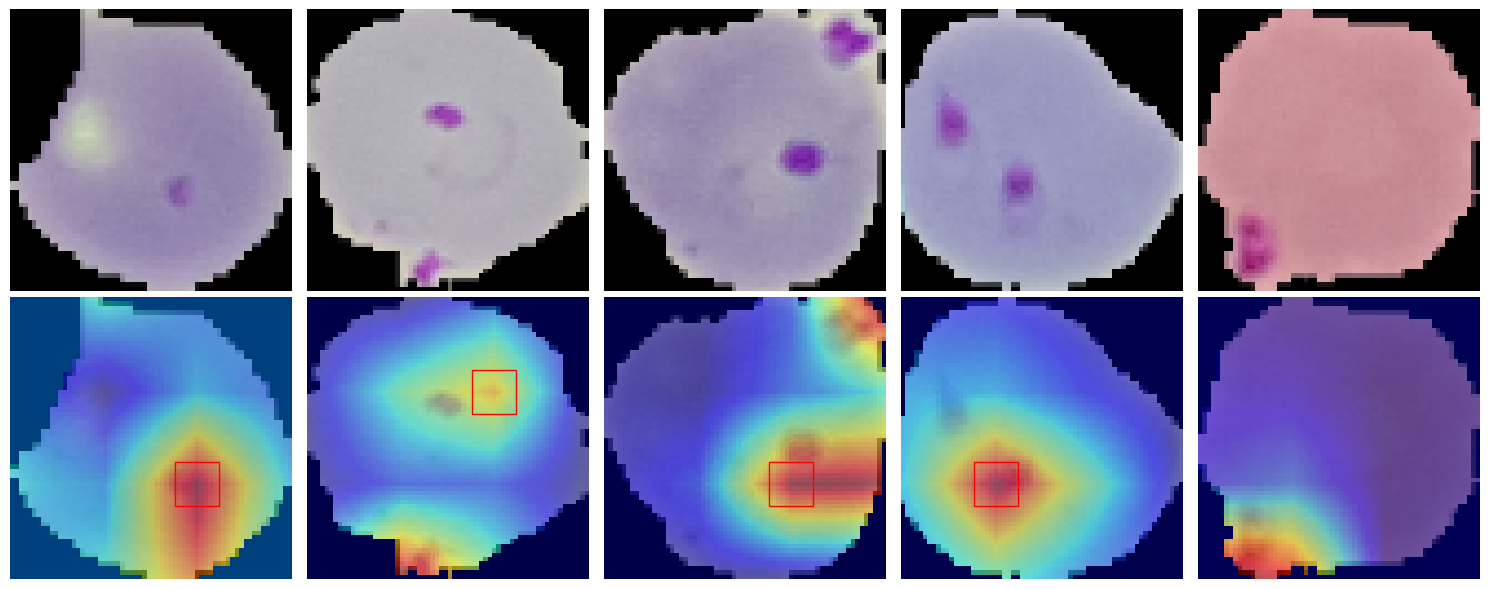

In [32]:
import random

def display_images_with_heatmaps(X_test, predicted_classes, model, layer_name='conv2d_7', save_path='random_heatmap_plots.png'):
    """
    Displays and saves a plot with randomly selected original images of infected cells
    and their corresponding heatmap images, including rectangles around detected peaks.

    Parameters:
    - X_test: The test dataset images.
    - predicted_classes: The array of predicted classes for each image in X_test.
    - model: The trained model to use.
    - layer_name: The name of the last convolutional layer in the model, used for generating heatmaps.
    - save_path: Path where the combined plot will be saved.
    """
    predicted_as_para = load_predicted_images(X_test, predicted_classes, class_idx=0)
    
    # Number of sample images
    num_images = 5
    
    # Randomly select images
    selected_indices = random.sample(range(len(predicted_as_para)), num_images)
    selected_images = [predicted_as_para[i] for i in selected_indices]
    
    fig, axs = plt.subplots(2, num_images, figsize=(15, 6))
    
    for i, imgage in enumerate(selected_images):
        # Generate heatmap for the selected image
        heat_map = class_activation_map(imgage, model, layer_name)
        
        # Detect peaks for rectangle drawing
        peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10)
        
        # Plot original image
        axs[0, i].imshow(imgage.astype('float32'))
        axs[0, i].axis('off')  
        
        # Plot heatmap image
        axs[1, i].imshow(imgage.astype('float32'))
        axs[1, i].imshow(heat_map, cmap='jet', alpha=0.5)  # Overlay heatmap
        for y, x in peak_coords:
            axs[1, i].add_patch(Rectangle((x-5, y-5), 10, 10, linewidth=1, edgecolor='r', facecolor='none'))
        axs[1, i].axis('off')  
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

display_images_with_heatmaps(X_test, predicted_classes, model, layer_name='conv2d_7', save_path='heatmap_plots.png')
